In [1]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

In [14]:
%matplotlib inline

import datetime
import glob
import joblib
import os
import time
import pandas as pd
import numpy as np
from numpy import dot
from numpy.linalg import norm
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import regularizers

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

import seaborn as sns
# sns.set(context='paper', style='whitegrid', color_codes=True)   
sns.set_palette(sns.color_palette(["#017b92", "#f97306", "#0485d1"]))  # ["jade green", "orange", "blue"] 

## Constants

In [3]:
cfg_sequence_len = 36        # default=24
cfg_sequence_len_y = 1
cfg_steps_ahead = 1

cfg_batch_size = 1
cfg_units = 36              # default=36
cfg_dropout_rate = 0.2      

cfg_num_epochs = 100
cfg_epochs_patience = 10

cfg_fig_size_x = 20
cfg_fig_size_y = 5
 
data_train_filename = 'data/mha_data_train.tsv'
data_test_filename = 'data/mha_data_test.tsv'

model_name = 'models/MHA_model'

## Functions

In [4]:
# pandas dataframe to numpy array
def read_data(filename):
    df = pd.read_csv(filename, sep='\t', skiprows=0, skipfooter=0, engine='python')
    data = df.values
    print('read_data: ', filename, '\t', data.shape[1], data.dtype, '\n', list(df))
    return data


# data is numpy array
def transform(data, epsilon=1):
    data = np.where(data < 0, epsilon, data)
    return data


# Scale all metrics but each separately: normalization or standardization
def normalize(data, scaler=None):
    if not scaler:
        scaler = MinMaxScaler(feature_range=(0, 1))
        norm_data = scaler.fit_transform(data)
    else:
        norm_data = scaler.transform(data)
    # print('\nnormalize:', norm_data.shape)
    return norm_data, scaler


def make_timeseries(data,
                    sequence_len=cfg_sequence_len,
                    sequence_len_y=cfg_sequence_len_y,
                    steps_ahead=cfg_steps_ahead
                    ):
    data_x = data_y = data

    if sequence_len_y > 1:
        for i in range(1, sequence_len_y):
            data_y = np.column_stack((data_y[:-1], data[i:]))
        data_x = data_x[:-(sequence_len_y-1)]

    if steps_ahead > 1:
        data_x = data_x[:-(steps_ahead-1)]
        data_y = data_y[steps_ahead-1:]

    tsg_data = TimeseriesGenerator(data_x, data_y, length=sequence_len,
                                   sampling_rate=1, stride=1, batch_size=cfg_batch_size)
    # x, y = tsg_data[0]
    # print('\ttsg x.shape=', x.shape, '\n\tx=', x, '\n\ttsg y.shape=', y.shape, '\n\ty=', y)
    return tsg_data


def transform_invert(data, denorm, sequence_len=cfg_sequence_len, steps_ahead=cfg_steps_ahead):
    begin = sequence_len + steps_ahead -1           # indexing is from 0
    end = begin + len(denorm)
    Y = data[begin:end]                             # excludes the end index
    return denorm, Y


def fit_model(data_train, data_test, model, epochs, scaler, callbacks_list):
    trans_train = transform(data_train)
    norm_train, _ = normalize(trans_train, scaler)
    tsg_train = make_timeseries(norm_train)
    
    trans_test = transform(data_test)
    norm_test, _ = normalize(trans_test, scaler)
    tsg_test = make_timeseries(norm_test)
    history = model.fit(tsg_train, epochs=epochs, callbacks=callbacks_list, validation_data=tsg_test)
    return model, history


def predict(data_test, model, scaler):
    trans_test = transform(data_test)
    norm_test, _ = normalize(trans_test, scaler)
    tsg_test = make_timeseries(norm_test)
    return model.predict(tsg_test)

## Functions: evaluation + plot

In [5]:
def mape(y_true, y_pred):
    assert isinstance(y_true, np.ndarray), 'numpy array expected for y_true in mape'
    assert isinstance(y_pred, np.ndarray), 'numpy array expected for y_pred in mape'
    score = []
    for i in range(y_true.shape[1]):
        try:
            s = np.mean(np.abs((y_true[:,i] - y_pred[:,i]) / y_true[:,i])) * 100
            if np.isnan(s):
                s = str(s)
            score.append(s)
        except ZeroDivisionError:
            score.append(str(np.nan))
    return score


# @giang: RMSE for numpy array
def rmse(a, b):
    score = []
    for i in range(a.shape[1]):
        score.append(sqrt(mean_squared_error(a[:,i], b[:,i])))
    return score


# @giang: cosine similarity for two numpy arrays, <-1.0, 1.0>
def cosine(a, b):
    score = []
    for i in range(a.shape[1]):
        cos_sim = dot(a[:, i], b[:, i]) / (norm(a[:, i]) * norm(b[:, i]))
        score.append(cos_sim)
    return score


# @giang: R^2 (coefficient of determination) regression score, <-1.0, 1.0>, not a symmetric function
def r2(a, b):
    score = []
    for i in range(a.shape[1]):
        score.append(r2_score(a[:, i], b[:, i]))
    return score


def eval_predictions(pred_test, Y_test, model_type):
    print('\nEvaluation with real values - One step')
    results = [model_type]

    err_train = err_test = 0
    for m in ['MAPE', 'RMSE', 'R2', 'COSINE']:
        if m == 'MAPE':
            err_test  = mape(Y_test,  pred_test)
        elif m == 'RMSE':
            err_test  = rmse(Y_test,  pred_test)
        elif m == 'R2':
            err_test  = r2(Y_test,  pred_test)
        elif m == 'COSINE':
            err_test  = cosine(Y_test,  pred_test)
        results.append([m, err_train, err_test])

    line = results[0]                   # model_type
    for r in results[1:]:
        line += '\t' + r[0] + '\t'      # SMAPE, MAPE, R2, COSINE
        line += '\t'.join(x if isinstance(x, str) else str("{0:0.4f}".format(x)) for x in r[2])  # test
    print(line)
    return line


def plot_predictions(pred_test, Y_test, multivariate,
                     fig_x=cfg_fig_size_x,
                     fig_y=cfg_fig_size_y
                     ):
    plt.rcParams["figure.figsize"] = (fig_x, fig_y)
    if multivariate > 1:
        fig, ax = plt.subplots(multivariate, sharex=False, figsize=(fig_x, multivariate*fig_y))
        for i in range(multivariate):
            ax[i].plot(Y_test[:, i])
            ax[i].plot(pred_test[:, i])
    else:
        fig, ax = plt.subplots(figsize=(fig_x, multivariate*fig_y))
        ax.plot(Y_test[:, 0])
        ax.plot(pred_test[:, 0])

    fig.tight_layout()
    plt.savefig('models/plot_image', bbox_inches='tight')
    plt.show()
    return

## Train data + scaler

In [6]:
data_train = read_data(data_train_filename)
trans_train = transform(data_train)
norm_train, scaler = normalize(trans_train)

# save scaler
scaler_filename = model_name + '.scaler'
joblib.dump(scaler, scaler_filename)
print('Scaler saved to: ', scaler_filename)

read_data:  data/mha_data_train.tsv 	 2 float64 
 ['meanCPUUsage', 'CanonicalMemUsage']
Scaler saved to:  models/MHA_model.scaler


## Test data

In [7]:
data_test = read_data(data_test_filename)

read_data:  data/mha_data_test.tsv 	 2 float64 
 ['meanCPUUsage', 'CanonicalMemUsage']


## Create + compile model

In [8]:
# create model
print('Model typ: MLP')
multivariate = data_train.shape[1]

x = Input(shape=(cfg_sequence_len, multivariate))              
h = Dense(units=cfg_units, 
          activation='elu', 
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4),
          activity_regularizer=regularizers.l2(1e-5))(x)
h = Flatten()(h)
y = Dense(units=multivariate*cfg_sequence_len_y, activation='sigmoid')(h)
    
model = Model(inputs=x, outputs=y)
print(model.summary())

# compile model
opt = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])     # 'cosine', 'mape'

Model typ: MLP
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 2)]           0         
_________________________________________________________________
dense (Dense)                (None, 36, 36)            108       
_________________________________________________________________
flatten (Flatten)            (None, 1296)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2594      
Total params: 2,702
Trainable params: 2,702
Non-trainable params: 0
_________________________________________________________________
None


## Fit + save model

In [9]:
earlystops = EarlyStopping(monitor='loss', patience=cfg_epochs_patience, verbose=1)
callbacks_list = [earlystops]

# fit model
model, history = fit_model(data_train, data_test, model, cfg_num_epochs, scaler, callbacks_list)

# save model
model.save(model_name)
print('\nSave trained model: ', model_name)

Epoch 1/100
1815/1815 [==============================] - 1s 590us/step - loss: 0.0115 - mse: 0.0109 - mae: 0.0780 - val_loss: 0.0066 - val_mse: 0.0060 - val_mae: 0.0493
Epoch 2/100
1815/1815 [==============================] - 1s 482us/step - loss: 0.0041 - mse: 0.0035 - mae: 0.0441 - val_loss: 0.0060 - val_mse: 0.0054 - val_mae: 0.0469
Epoch 3/100
1815/1815 [==============================] - 1s 484us/step - loss: 0.0035 - mse: 0.0030 - mae: 0.0407 - val_loss: 0.0056 - val_mse: 0.0051 - val_mae: 0.0484
Epoch 4/100
1815/1815 [==============================] - 1s 483us/step - loss: 0.0032 - mse: 0.0027 - mae: 0.0401 - val_loss: 0.0072 - val_mse: 0.0068 - val_mae: 0.0535
Epoch 5/100
1815/1815 [==============================] - 1s 472us/step - loss: 0.0029 - mse: 0.0025 - mae: 0.0382 - val_loss: 0.0053 - val_mse: 0.0049 - val_mae: 0.0474
Epoch 6/100
1815/1815 [==============================] - 1s 476us/step - loss: 0.0029 - mse: 0.0025 - mae: 0.0382 - val_loss: 0.0056 - val_mse: 0.0052 - va

1815/1815 [==============================] - 1s 464us/step - loss: 0.0026 - mse: 0.0024 - mae: 0.0377 - val_loss: 0.0054 - val_mse: 0.0053 - val_mae: 0.0459
Epoch 50/100
1815/1815 [==============================] - 1s 475us/step - loss: 0.0026 - mse: 0.0025 - mae: 0.0374 - val_loss: 0.0054 - val_mse: 0.0053 - val_mae: 0.0458
Epoch 51/100
1815/1815 [==============================] - 1s 486us/step - loss: 0.0024 - mse: 0.0023 - mae: 0.0361 - val_loss: 0.0053 - val_mse: 0.0051 - val_mae: 0.0457
Epoch 52/100
1815/1815 [==============================] - 1s 473us/step - loss: 0.0026 - mse: 0.0025 - mae: 0.0370 - val_loss: 0.0050 - val_mse: 0.0049 - val_mae: 0.0448
Epoch 53/100
1815/1815 [==============================] - 1s 486us/step - loss: 0.0025 - mse: 0.0024 - mae: 0.0372 - val_loss: 0.0060 - val_mse: 0.0059 - val_mae: 0.0498
Epoch 54/100
1815/1815 [==============================] - 1s 481us/step - loss: 0.0024 - mse: 0.0023 - mae: 0.0364 - val_loss: 0.0053 - val_mse: 0.0052 - val_mae: 

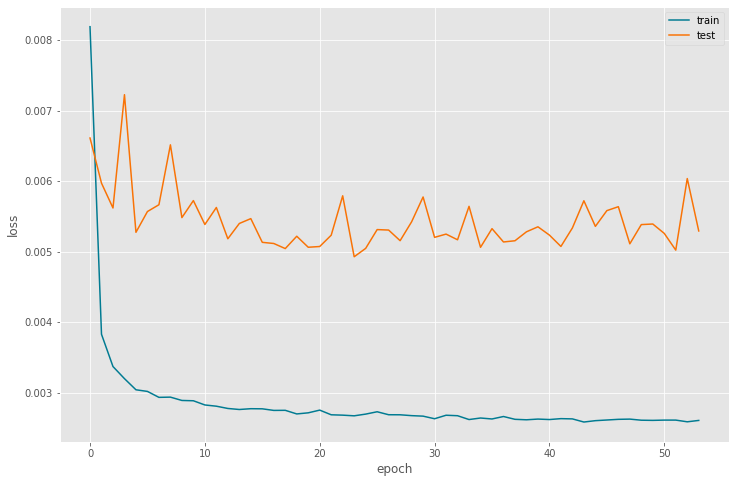

In [10]:
# plot
# print(history.history.keys())
plt.rcParams["figure.figsize"] = (12, 8)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

## Predict + Evaluation + Plot


Evaluation with real values - One step
NN	MAPE	10.4896	4.7358	RMSE	0.1241	0.0200	R2	0.6772	0.7950	COSINE	0.9906	0.9966


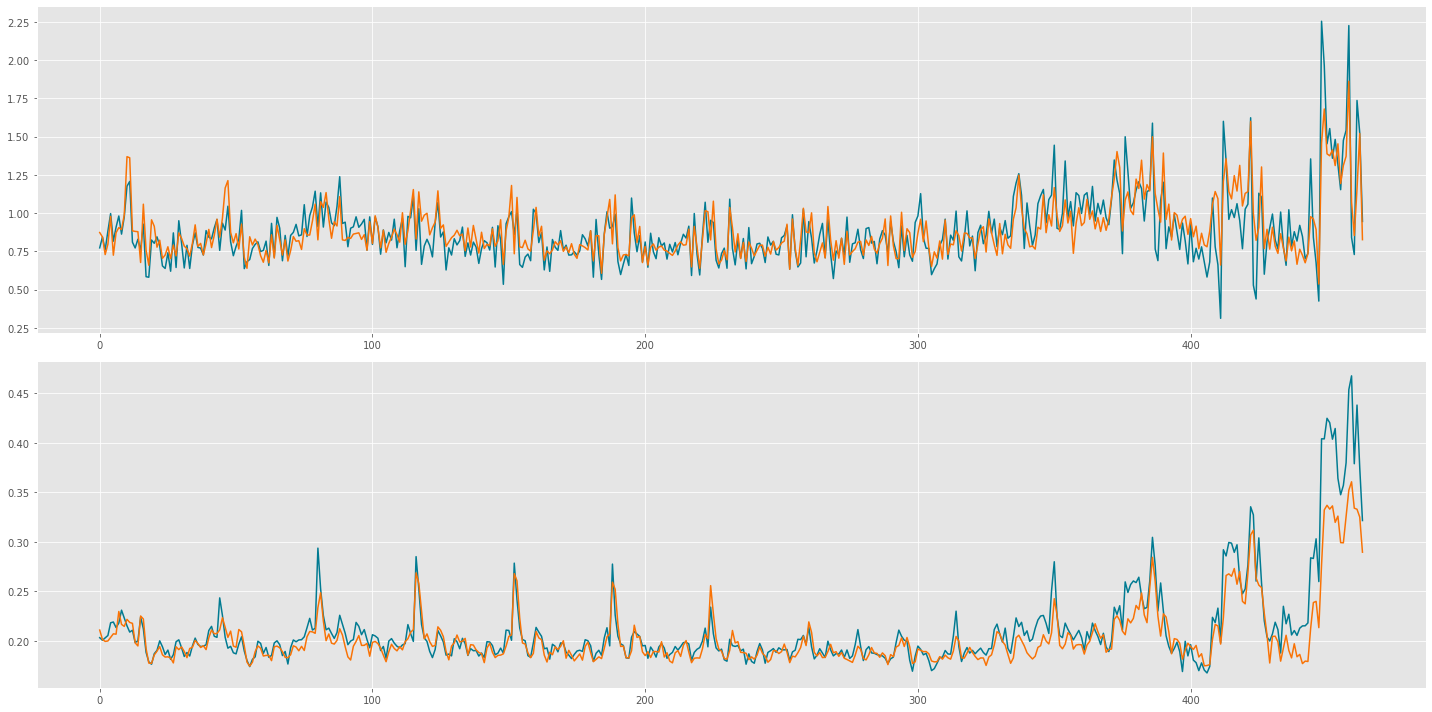

In [15]:
pred_model = predict(data_test, model, scaler)

eval_line = ''
for i in range(cfg_sequence_len_y):
    one_y_test = pred_model[:, i * multivariate:(i+1) * multivariate]
    denorm_test = scaler.inverse_transform(one_y_test)
    pred_test, Y_test = transform_invert(data_test, denorm_test, cfg_sequence_len, cfg_steps_ahead)

    # Evaluate with real values
    eval_line += str(i+1) + '\t' + eval_predictions(pred_test, Y_test, 'NN') + '\n'
    
    # Plot
    plot_predictions(pred_test, Y_test, multivariate)